# Topographic slope and along-slope velocity

Topographic gradient is  $$(\partial h / \partial x, \partial h / \partial y) $$
and along-slope velocity is projection of velocity onto tropographic gradient
$$ u_{along} = (u,v) \bullet \left(\frac{\partial h}{\partial y} (\partial h / \partial x ^2 + \partial h / \partial y ^2)^{-\frac{1}{2}} , -\frac{\partial h}{\partial x}(\partial h / \partial x ^2 + \partial h / \partial y ^2)^{-\frac{1}{2}} \right) $$ 

This script plots a map of the topographic gradient and a ten year average of the along-slope velocity for the upper 500 m water column. 

Load modules

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
from cosima_cookbook import distributed as ccd
# Optional modules
import cmocean as cm                              # Nice colormaps
import cftime                                     # In case you need to work with time axes
from matplotlib.gridspec import GridSpec
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:41529 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


Nominate a database from which to load the data and define an experiment:

In [3]:
# Load database
session = cc.database.create_session()#('/g/data/ik11/databases/ryf9091.db')
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [25]:
lat_slice = slice(-90, -59)

#### Topographic gradient

In [8]:
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [26]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [27]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Same as: (other option)
#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [28]:
# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

#### Along-slope velocity

In [59]:
start_time = '2080-01-01'
end_time   = '2089-12-31'

u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
u = u.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0,500))
u = u.sel(yu_ocean=lat_slice) 
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
v = v.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0,500))
v = v.sel(yu_ocean=lat_slice) 

1) Depth-average

In [30]:
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)

In [31]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0,500))

In [60]:
u = (u * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v = (v * thickness).sum('st_ocean') / thickness.sum('st_ocean')

2. Rotate to get along-slope component

In [61]:
u_along = u*dhu_dy/slope - v*dhu_dx/slope
u_along = u_along.load()

#### Plotting

In [34]:
ft_size  = 22
fig_path = '/g/data/x77/wgh581/Figures/'

In [35]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [55]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

In [62]:
# Masking
# Load the isobath information
def load_isobath(isobath_depth):
    file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_infos_' + str(isobath_depth) + 'm.npz'
    return np.load(file_path)
data_2500 = load_isobath(2500)
u_slope = np.ma.masked_where((data_2500['contour_masked_above'] ) != 0, u_along) 
u_outer = np.ma.masked_where((data_2500['contour_masked_above'] ) == 0, u_along)

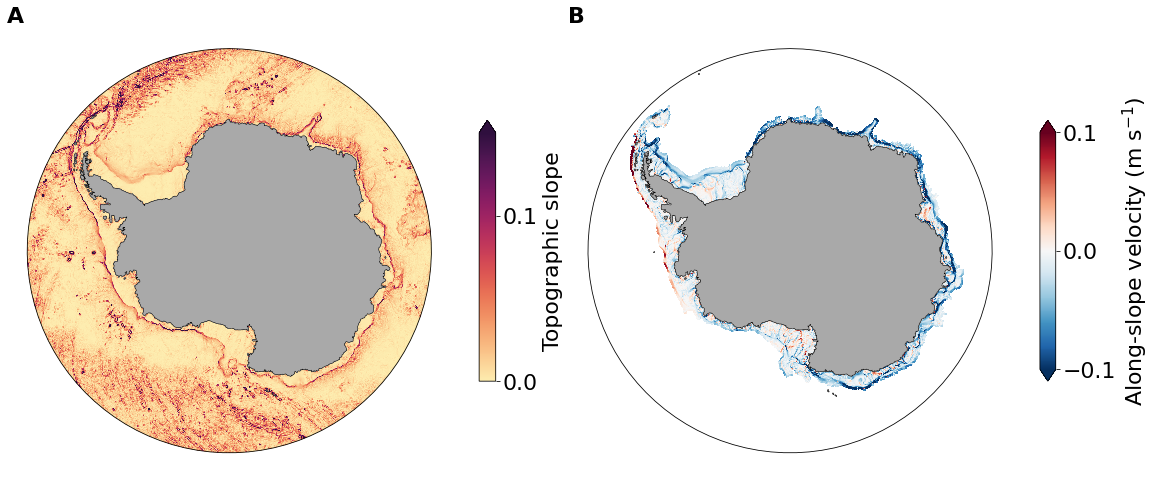

In [63]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Plot land
    ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
    ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
    # Plot velocity
    if ii == 1:
        plt.title('B', fontsize=ft_size, fontweight='bold', loc='left')
        #plt.title('Along-slope', fontsize=ft_size)
        sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_slope, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        #ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_outer, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1, alpha=0.02)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.2, 0.25, 0.1), aspect=15)
        cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
    elif ii == 0:
        plt.title('A', fontsize=ft_size, fontweight='bold', loc='left')
        #plt.title('Cross-slope', fontsize=ft_size)
        sc  = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, slope, transform = ccrs.PlateCarree(), cmap=cm.cm.matter, vmin=0, vmax=0.15)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, ticks=np.arange(0, 0.25, 0.1), extend='max', aspect=15)
        cbar.set_label('Topographic slope', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

# Save figure
save_fig = 1
if save_fig == 1:
    fig.savefig(fig_path + 'Fig_topographic_gradient_along_slope_vel_500m_map_alpha.png', dpi=150, bbox_inches='tight', facecolor='white')